In [2]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
import importlib
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import CleanData, SaveState
from CleanData import clean_comment, get_bag_of_words


# Load all article reviews from MediaBiasChart V5.0:
media_bias = pd.read_csv('../data/MediaBiasChart.csv')
media_bias = media_bias.groupby('Source').mean()
media_bias.reset_index(level=0, inplace=True)

MediaBiasChart_to_Tweet = {'ABC':'ABC','AP':'AP','Axios':'axios','CNN':'CNN','Wall Street Journal':'WSJ',\
    'The Atlantic':'TheAtlantic','The Hill':'thehill', 'BBC':'BBC', 'Think Progress':'thinkprogress',\
    'MSNBC':'MSNBC','The Nation':'thenation','Daily Beast':'thedailybeast','Mother Jones':'MotherJones',\
    'CNSNews':'cnsnews','Fox News':'FoxNews', 'The Federalist':'FDRLST','Breitbart':'BreitbartNews',\
    'Daily Caller':'DailyCaller','The Blaze':'theblaze','Business Insider':'businessinsider',\
    'CBS':'CBSNews','The Economist':'TheEconomist','BuzzFeed':'BuzzFeed','Daily Signal':'DailySignal',\
    'New Republic':'newrepublic','Foreign Policy':'ForeignPolicy','IJR':'TheIJR','National Review':'NRO',\
    'National Public Radio':'NPR','New York Post':'nypost','New York Times':'nytimes','The New Yorker':'NewYorker',\
    'NewsMax':'newsmax','One America News Network':'OANN','Politico':'politico','Quartz':'qz',\
    'Reason':'reason','Reuters':'Reuters','Slate':'Slate','Talking Points Memo':'TPM','Vanity Fair':'VanityFair',\
    'Vox':'voxdotcom','Washington Examiner':'dcexaminer','Washington Free Beacon':'FreeBeacon',\
    'Washington Post':'washingtonpost','Washington Times':'WashTimes','The Week':'TheWeek','Bloomberg':'Bloomberg',\
    'Christian Science Monitor':'csmonitor', 'Democracy Now':'democracynow','Financial Times':'FT',\
    'Fiscal Times':'TheFiscalTimes','Forbes':'Forbes','Fortune':'FortuneMagazine','Forward':'jdforward',\
    'FreeSpeech TV':'freespeechtv','Huffington Post':'HuffPost','LA Times':'latimes','Marketwatch':'MarketWatch',\
    'OZY':'ozy','PBS':'PBS','ProPublica':'propublica','Time':'TIME','USA Today':'USATODAY',\
    'Weather.com':'weatherchannel'}

media_bias['Source'] = media_bias.Source.map(MediaBiasChart_to_Tweet)
media_bias = media_bias.dropna()
# media_bias = media_bias.drop('Source2', axis=1)
media_bias = media_bias.reset_index(drop=True)
media_bias

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zchao\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Source,Bias,Quality
0,ABC,-1.846000,49.866500
1,AP,-1.063261,52.189130
2,axios,-5.737857,47.303571
3,BBC,-3.033333,46.266667
4,Bloomberg,-0.850345,47.522759
...,...,...,...
60,dcexaminer,12.166250,35.485000
61,FreeBeacon,16.708125,36.187500
62,washingtonpost,-4.179888,44.567303
63,WashTimes,12.966667,37.228000


In [3]:
media_bias.to_csv('../data/Media_coordinate.csv',index=False)

In [4]:
df1 = pd.read_csv('../data/filtered_part1.csv', skiprows=1)
df2 = pd.read_csv('../data/filtered_part2.csv')
df3 = pd.read_csv('../data/filtered_part3.csv')
df4 = pd.read_csv('../data/filtered_part4.csv',lineterminator='\n')
df6 = pd.read_csv('../data/filtered_part6.csv')
df7 = pd.read_csv('../data/filtered_part7.csv')
df8 = pd.read_csv('../data/filtered_part8.csv')
df = pd.concat([df1, df2, df3, df4, df6, df7, df8], sort = False)

all_media = media_bias['Source'].tolist()
df = df.loc[df['user_screen_name'].isin(all_media)]
df = df.drop(columns=['hashtags','created_at'])
print(df.shape)

df.to_csv('../data/filtered_all.csv',index=False)

tweet_count = df.groupby(by=["user_screen_name"]).count()
tweet_count['text'].nsmallest(10)

(1418451, 2)


user_screen_name
Bloomberg          127
propublica        1421
thenation         2438
TheFiscalTimes    3256
TheIJR            4860
PBS               4992
newsmax           5056
cnsnews           5459
BBC               5660
ozy               5944
Name: text, dtype: int64

In [5]:
df_10000 = df.groupby('user_screen_name').sample(n=10000, frac=None, replace=True, weights=None, random_state=None).reset_index(drop=True)
df_10000.to_csv('../data/media_10k_per.csv',index=False)
print(df_10000.shape)

(650000, 2)


In [7]:
# df2 = pd.read_csv('../data/filtered_all.csv')
df2 = pd.read_csv('../data/media_10k_per.csv')
coor = pd.read_csv('../data/Media_coordinate.csv')
def assign_coor(df, coor):
    media2bias = dict(zip(coor.Source, coor.Bias))
    df['bias'] = df['user_screen_name'].map(media2bias)
    df['bias'] = df['bias']/df['bias'].abs().max()
    media2qual = dict(zip(coor.Source, coor.Quality))
    df['quality'] = df['user_screen_name'].map(media2qual)
    df['quality'] = df['quality'] - df['quality'].abs().min()
    df['quality'] = df['quality']/df['quality'].abs().max()
    df = df.sample(frac=1,replace=True).reset_index(drop=True)
    return df
    
df = assign_coor(df2, coor)
print(df.shape)

(650000, 4)


Text(0, 0.5, 'Number of Tweets')

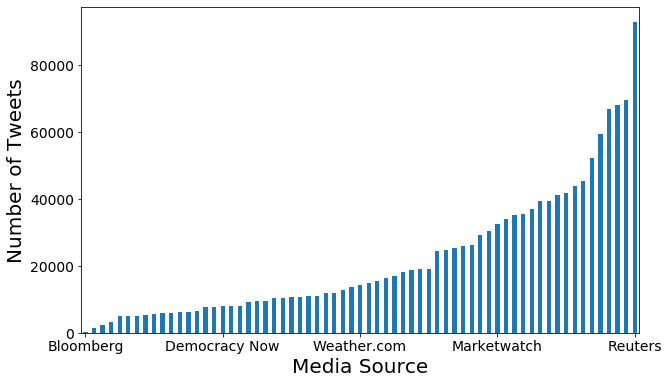

In [5]:
Tweet_to_AFMBC = {v: k for k, v in MediaBiasChart_to_Tweet.items()}
ct = df.groupby('user_screen_name').count()
ct = ct.sort_values(by=['text'])
ct.index = ct.index.map(Tweet_to_AFMBC)
ax = ct.plot(y='text', kind='bar', xticks=[0,1], legend = False, rot=0, figsize=(10, 6))
ax.set_xticks([0,16,32,48,64])
ax.set_xticklabels(ct.index[0:65:16])
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel("Media Source", fontsize = 20)
ax.set_ylabel("Number of Tweets",  fontsize = 20)

In [9]:
stop_words = stopwords.words('english')
number_strs = ['one', 'two', 'three', 'four', 'five', 'six', 'seven','eight', 'nine', 'ten']
stop_words.extend(number_strs)
clean_c = lambda x: clean_comment(x)
X = list(map(clean_c, df.text))

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
vectorizer = CountVectorizer(max_features = 5000)
bag_of_words = vectorizer.fit_transform(X)
bag_of_words.shape

(650000, 5000)

In [22]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import scipy
kf = KFold(n_splits=5)


for train, test in kf.split(bag_of_words):
    X_train, X_test, yb_train, yb_test = bag_of_words[train], bag_of_words[test], df.bias[train], df.bias[test]
    regr1 = make_pipeline(StandardScaler(with_mean=False), LinearSVR(random_state=0, tol=1e-4,max_iter=200))
    regr1.fit(X_train, yb_train)
    bias_pred = regr1.predict(X_test)
# X_train, X_test, yb_train, yb_test = train_test_split(bag_of_words, df.bias, test_size=0.8,shuffle=False)
# regr1 = make_pipeline(StandardScaler(with_mean=False), LinearSVR(random_state=0, tol=1e-4,max_iter=1000))
# regr1.fit(X_train, yb_train)
    bias_pred = regr1.predict(X_test)

    yq_train, yq_test = df.quality[train], df.quality[test]
    regr2 = make_pipeline(StandardScaler(with_mean=False), LinearSVR(random_state=0, tol=1e-4,max_iter=200))
    regr2.fit(X_train, yq_train)
# X_train, X_test, yq_train, yq_test = train_test_split(bag_of_words, df.quality, test_size=0.8,shuffle=False)
# regr2 = make_pipeline(StandardScaler(with_mean=False), LinearSVR(random_state=0, tol=1e-4,max_iter=1000))
# regr2.fit(X_train, yq_train)
    qual_pred = regr2.predict(X_test)

 
    df_test = df.tail(X_test.shape[0]).copy()
    df_test['bias_pred'] = bias_pred
    df_test['qual_pred'] = qual_pred
    df_gb = df_test.groupby(['user_screen_name'])
    corr_bias = scipy.stats.pearsonr(df_gb.bias_pred.mean().tolist(), df_gb.bias.mean().tolist())[0]
    corr_quality = scipy.stats.pearsonr(df_gb.qual_pred.mean().tolist(), df_gb.quality.mean().tolist())[0]
(corr_bias,corr_quality)

(0.8778384729467886, 0.8642208532571041)

In [ ]:
from sklearn.neural_network import MLPRegressor

for train, test in kf.split(bag_of_words):
    X_train, X_test, yb_train, yb_test = bag_of_words[train], bag_of_words[test], df.bias[train], df.bias[test]
    regr1 = MLPRegressor(hidden_layer_sizes=10, shuffle=False, random_state=1).fit(X_train, yb_train)
    bias_pred = regr1.predict(X_test)
    yq_train, yq_test = df.quality[train], df.quality[test]
    regr2 = MLPRegressor(hidden_layer_sizes=10, shuffle=False, random_state=1).fit(X_train, yq_train)
    qual_pred = regr2.predict(X_test)

    df_test = df.tail(X_test.shape[0]).copy()
    df_test['bias_pred'] = bias_pred
    df_test['qual_pred'] = qual_pred
# df_gb = df_test.groupby(['user_screen_name'])
# corr_bias = scipy.stats.pearsonr(df_gb.bias_pred.mean().tolist(), df_gb.bias.mean().tolist())[0]
# corr_quality = scipy.stats.pearsonr(df_gb.qual_pred.mean().tolist(), df_gb.quality.mean().tolist())[0]
# (corr_bias,corr_quality)
    average_bias = df_test.groupby(['user_screen_name']).bias_pred.mean()
    average_qual = df_test.groupby(['user_screen_name']).qual_pred.mean()
    bias = df_test.groupby(['user_screen_name']).bias.mean()
    quality = df_test.groupby(['user_screen_name']).quality.mean()

    corr_bias = scipy.stats.pearsonr(average_bias.tolist(), bias.tolist())[0]
    corr_quality = scipy.stats.pearsonr(average_qual.tolist(), quality.tolist())[0]

print(corr_bias, corr_quality)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
for train, test in kf.split(bag_of_words):
    X_train, X_test, yb_train, yb_test = bag_of_words[train], bag_of_words[test], df.bias[train], df.bias[test]
    regr1 = DecisionTreeRegressor(random_state=1, max_depth = 100).fit(X_train, yb_train)
    bias_pred = regr1.predict(X_test)
    yq_train, yq_test = df.quality[train], df.quality[test]
    regr2 = DecisionTreeRegressor(random_state=1, max_depth = 100).fit(X_train, yq_train)
    qual_pred = regr2.predict(X_test)

    df_test = df.tail(X_test.shape[0]).copy()
    df_test['bias_pred'] = bias_pred
    df_test['qual_pred'] = qual_pred
    df_gb = df_test.groupby(['user_screen_name'])

    corr_bias = scipy.stats.pearsonr(df_gb.bias_pred.mean().tolist(), df_gb.bias.mean().tolist())[0]
    corr_quality = scipy.stats.pearsonr(df_gb.qual_pred.mean().tolist(), df_gb.quality.mean().tolist())[0]
(corr_bias,corr_quality)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
for train, test in kf.split(bag_of_words):
    X_train, X_test, yb_train, yb_test = bag_of_words[train], bag_of_words[test], df.bias[train], df.bias[test]
    regr1 = RandomForestRegressor(n_estimators=10).fit(X_train, yb_train)
    bias_pred = regr1.predict(X_test)
    yq_train, yq_test = df.quality[train], df.quality[test]
    regr2 = RandomForestRegressor(n_estimators=10).fit(X_train, yq_train)
    qual_pred = regr2.predict(X_test)

    df_test = df.tail(X_test.shape[0]).copy()
    df_test['bias_pred'] = bias_pred
    df_test['qual_pred'] = qual_pred
    df_gb = df_test.groupby(['user_screen_name'])

    corr_bias = scipy.stats.pearsonr(df_gb.bias_pred.mean().tolist(), df_gb.bias.mean().tolist())[0]
    corr_quality = scipy.stats.pearsonr(df_gb.qual_pred.mean().tolist(), df_gb.quality.mean().tolist())[0]
(corr_bias,corr_quality)